In [1]:
using Pkg
Pkg.instantiate()
Pkg.add("MCMCChains")
using TAMode
using Plots
using StaticArrays
using LinearAlgebra

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/TAMode.jl/Project.toml`
 [no changes]
   Updating `~/TAMode.jl/Manifest.toml`
 [no changes]
┌ Info: Precompiling TAMode [294f26d0-a9c2-4f6a-959f-92a060cb6778]
└ @ Base loading.jl:1260


In [3]:
tpsA549 = @SVector Float64[60, 240];
gasA549 = @SVector Float64[64, 16, 4, 1, 0.25, 0];
pYA549 = @SMatrix [10.8 8.3; 7.4 7.1; 7.1 7.7; 4.6 8.2; 6.1 7.2; 7.5 7.5];
totA549 = @SMatrix [3443.1 3219.7; 3143.4 3353.8; 3018.9 3611.8; 2608.9 3448.2; 2690.2 3168.1; 2672.0 2672.0];
surfA549 = @SMatrix [0.206 0.239; 0.274 0.316; 0.281 0.251; 0.220 0.302; 0.256 0.281; 0.257 0.337];

In [5]:
using MCMCChains
chn = read("chain-file2.jls", Chains);
summarize(chn)

Summary Statistics
     parameters     mean     std  naive_se    mcse       ess   r_hat
  ─────────────  ───────  ──────  ────────  ──────  ────────  ──────
        AXLexpr   1.7210  2.0424    0.1292  0.1258  218.5290  0.9966
         Ig2rev   1.4792  1.8447    0.1167  0.0795  261.6473  1.0019
         gasCur   0.0998  0.0097    0.0006  0.0001  373.0543  0.9962
    internalize   0.1013  0.0102    0.0006  0.0007  310.9932  0.9993
           kDeg   0.0101  0.0009    0.0001  0.0001  376.2970  0.9961
           kRec   0.1005  0.0108    0.0007  0.0007  582.1049  0.9979
  pYinternalize   1.0010  0.1052    0.0067  0.0030  397.8988  0.9967
          scale   2.0032  2.6946    0.1704  0.1036  134.7807  1.0096
      scaleSurf   1.7003  2.1861    0.1383  0.3949  238.4753  1.0203
          sortF   0.0857  0.0770    0.0049  0.0002  311.9824  1.0016
        sqResid  35.8969  8.4736    0.5359  0.1705  314.0227  0.9975
           xFwd   0.0848  0.0997    0.0063  0.0013  287.1508  1.0038


In [17]:
x = get(chn, [:internalize, :pYinternalize, :sortF, :kRec, :kDeg, :xFwd, :gasCur, :AXLexpr])
samp_params = hcat(x.internalize, x.pYinternalize, x.sortF, x.kRec, x.kDeg, x.xFwd, x.gasCur, x.AXLexpr)

Ig2rev = get(chn, :Ig2rev)[1];
scale = get(chn, :scale)[1];
scaleSurf = get(chn, :scaleSurf)[1];

In [18]:
pY = Array{Float64}(undef, 250, length(tpsA549), length(gasA549));
tot = Array{Float64}(undef, 250, length(tpsA549), length(gasA549));
surf = Array{Float64}(undef, 250, length(tpsA549), length(gasA549));

for iter = 1:size(samp_params, 1)
    params = vcat(samp_params[iter, :], zeros(2), Ig2rev[iter], ones(4))
    pY[iter, :, :], tot[iter, :, :], surf[iter, :, :] = TAMode.dataModelCalc(tpsA549, gasA549, params, scale[iter], scaleSurf[iter])
end
    

In [19]:
using Statistics
medpY = Statistics.median(pY, dims = 1);
medtot = Statistics.median(tot, dims = 1);
medsurf = Statistics.median(surf, dims = 1);
stdsurf = Statistics.std(surf, dims = 1);
meanpY = Statistics.mean(pY, dims = 1);
meantot = Statistics.mean(tot, dims = 1);
meansurf = Statistics.mean(surf, dims = 1);

In [20]:
tp1_calcmean = hcat(transpose(meanpY[:,1,:]), transpose(meansurf[:,1,:]), transpose(meantot[:,1,:]));
tp2_calcmean = hcat(transpose(meanpY[:,2,:]), transpose(meansurf[:,2,:]), transpose(meantot[:,2,:]));
tp1_calcmed = hcat(transpose(medpY[:,1,:]), transpose(medsurf[:,1,:]), transpose(medtot[:,1,:]));
tp2_calcmed = hcat(transpose(medpY[:,2,:]), transpose(medsurf[:,2,:]), transpose(medtot[:,2,:]));
tp1_exp = hcat(pYA549[:,1], surfA549[:,1], totA549[:,1]);
tp2_exp = hcat(pYA549[:,2], surfA549[:,2], totA549[:,2]);

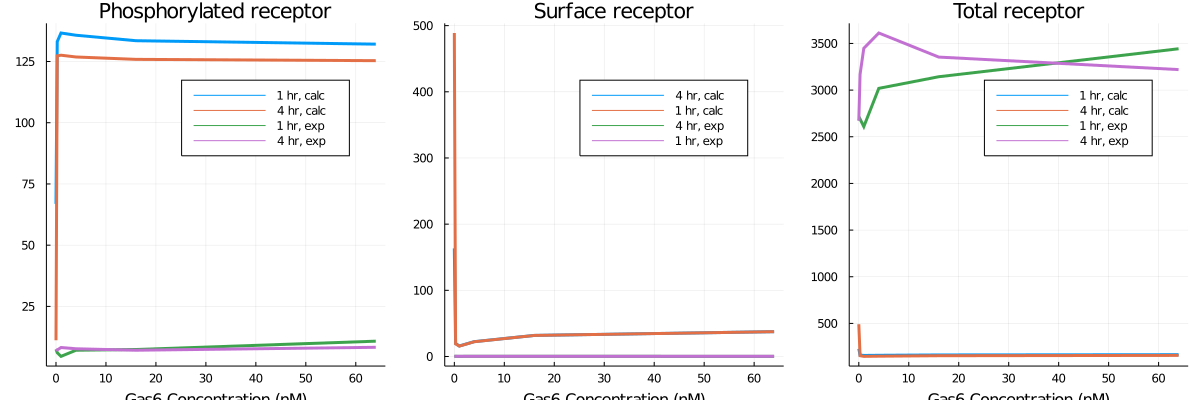

In [21]:
### mean
plot(gasA549, [tp1_calcmean, tp2_calcmean], 
        label=["1 hr, calc" "4 hr, calc"] , 
        title=["Phosphorylated receptor" "Surface receptor" "Total receptor"], 
        lw=3, 
        layout = (1,3), 
        size=(1200,400))
plot!(gasA549, [tp1_exp, tp2_exp], 
        label=["1 hr, exp" "4 hr, exp"], 
        lw=3,
        layout=(1,3))
        xlabel!("Gas6 Concentration (nM)")

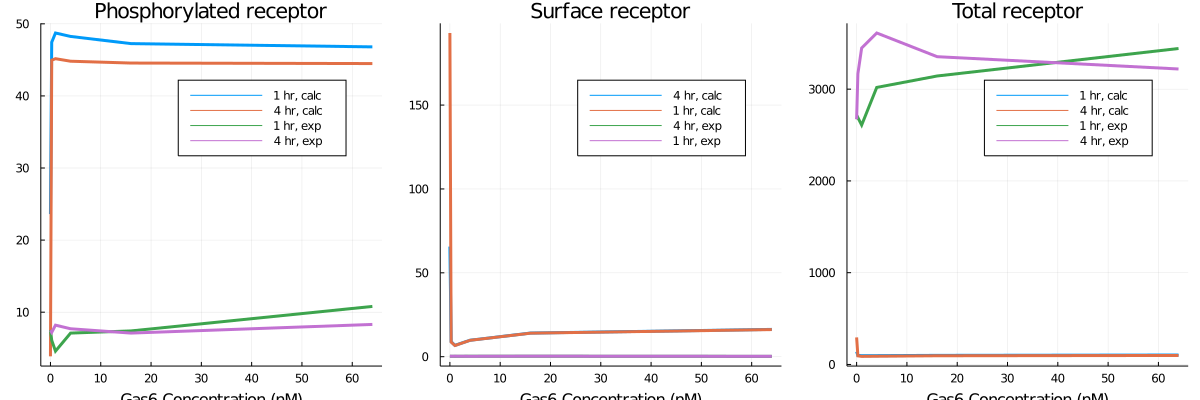

In [24]:
### meadian
plot(gasA549, [tp1_calcmed, tp2_calcmed], 
        label=["1 hr, calc" "4 hr, calc"] , 
        title=["Phosphorylated receptor" "Surface receptor" "Total receptor"], 
        lw=3, 
        layout = (1,3), 
        size=(1200,400))
plot!(gasA549, [tp1_exp, tp2_exp], 
        label=["1 hr, exp" "4 hr, exp"], 
        lw=3,
        layout=(1,3))
        xlabel!("Gas6 Concentration (nM)")